# Gett project

Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import datetime as dt
from datetime import time as t
from datetime import datetime as d

import seaborn as sns
import statistics
import math

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

### Датафрейм по заказам

In [3]:
data_orders_df = pd.read_csv(r"C:\Users\Asus\Desktop\Учеба\python\Gett\data_orders.csv")

data_orders_df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


Таблица 1

### Данные по заказам такси

In [4]:
data_offers_df = pd.read_csv(r"C:\Users\Asus\Desktop\Учеба\python\Gett\data_offers.csv")

data_offers_df.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [5]:
df_cancelled_orders = {'cancelled_by_client_dr_assig': 0, 'cancelled_by_client_dr_not_assig': 0, 'cancelled_by_system': 0, 'cancelled_by_client': 0}

**Отмененные заказы**:
* отмененные клиентом определенным водителем,
* отмененные клиентом с неопределенным водителем,
* отмененные системой

In [6]:
#проходим циклом (числами) по датафрейму из файла csv
for i in range(len(data_orders_df['order_gk'])):
    #Если отменил клиент и водитель был назначен
    if data_orders_df['is_driver_assigned_key'][i] == 1:
        df_cancelled_orders['cancelled_by_client_dr_assig'] += 1
    #Если отменил клиент и водитель не был назначен
    if data_orders_df['is_driver_assigned_key'][i] == 0:
        df_cancelled_orders['cancelled_by_client_dr_not_assig'] += 1
    #Если отменила система
    if data_orders_df['order_status_key'][i] == 9:
        df_cancelled_orders['cancelled_by_system'] += 1
    if data_orders_df['order_status_key'][i] == 4:
        df_cancelled_orders['cancelled_by_client'] += 1

df_cancelled_orders

{'cancelled_by_client_dr_assig': 2814,
 'cancelled_by_client_dr_not_assig': 7902,
 'cancelled_by_system': 3409,
 'cancelled_by_client': 7307}

Словарь с отмененными заказами

# Вопрос 1
***Построить распределение заказов в соответствии с причинами отмены: отмены до и после назначения водителя, а также причинами отказа от заказа. Проанализируйте полученный график. Какая категория имеет наибольшее количество заказов?***

* В таблице 1 можно разделить отказы от заказов по ряду причин**
    + Отказ после назначения водителя
    + Отказ до назначения водителя
    + Отказ клиента 
    + Отказ системы
* Но
    + Отказ системы возможен только в случае если водитель не назначен, а отказ клиента возможен в обоих случаях
    + Поэтому рассмортим все варинаты отдельно друг о друга

Text(0.5, 1.0, 'Distribution of orders cancellation')

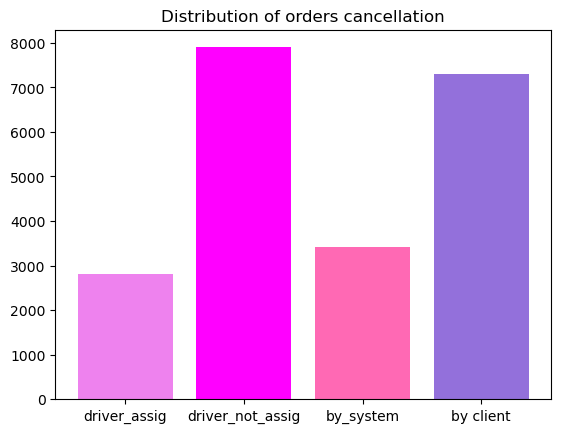

In [7]:
#создаем область (fig) для графиков
fig, ax = plt.subplots()
#цвета которые исользуем на графике
colors = ['violet', 'fuchsia', 'hotpink', 'mediumpurple']
#создаем график первое по оси x, второе по оси у
plt.bar(df_cancelled_orders.keys(), df_cancelled_orders.values(), color=colors)
#настраиваем в какой очередности будут дальше называться столбцы
ax.set_xticks(range(len(df_cancelled_orders)))
#Названия столбцов
ax.set_xticklabels(['driver_assig', 'driver_not_assig', 'by_system', 'by client'])
#Название графика
ax.set_title('Distribution of orders cancellation')

* На графике видно, что ситуации когда водитель не назначен и отмена произошла по инициативе клиента опережают другие ситуации отказов в два раза
+ В дальнейшем будет логично рассматривать отказы клиентов в двух ситуациях: назначен/не назначен водитель

### Сравниваем отказы клентов и системы при неназначенном водителе

In [8]:
dct_cancelled_2 = {'by_system': 0, 'by_client': 0}

#проходим циклом (числами) по датафрейму из файла csv
for i in range(len(data_orders_df['order_gk'])):
    #Если отменил клиент и водитель не был назначен
    if data_orders_df['is_driver_assigned_key'][i] == 0:
        if data_orders_df['order_status_key'][i] == 4:
            dct_cancelled_2['by_client'] += 1
        if data_orders_df['order_status_key'][i] == 9:
            dct_cancelled_2['by_system'] += 1

Text(0.5, 1.0, 'Distribution of orders cancellation')

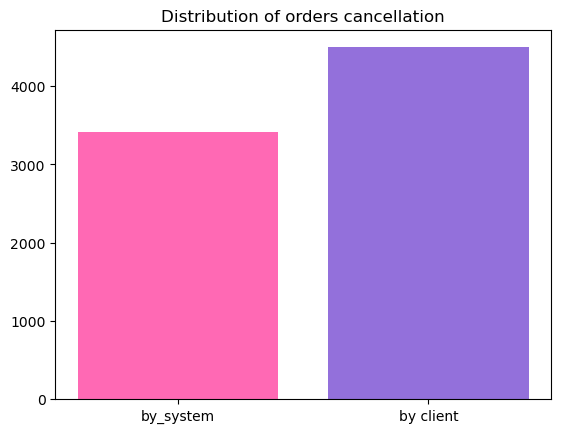

In [9]:
#создаем область (fig) для графиков
fig, ax = plt.subplots()
#цвета которые исользуем на графике
colors = [ 'hotpink', 'mediumpurple']
#создаем график первое по оси x, второе по оси у
plt.bar(dct_cancelled_2.keys(), dct_cancelled_2.values(), color=colors)
#настраиваем в какой очередности будут дальше называться столбцы
ax.set_xticks(range(len(dct_cancelled_2)))
#Названия столбцов
ax.set_xticklabels(['by_system', 'by client'])
#Название графика
ax.set_title('Distribution of orders cancellation')

* Здесь мы рассматриваем отмененные заказы в ситуации когда водитель не был назначен
+ Отказы клиентов в случае, когда водитель еще не был назначен лидируют
* Из этого можно сделать вывод чаще всего возникают ситуации, когда система не успевает назначить водителя до того как клиент отменяет заказ

Далее стоит рассмотреть как во времени соотносятся отказы в зависимости от причины

# Вопрос 2 
***Построить распределение отмененных заказов по часам. Есть ли тенденция, что в определенные часы преобладает аномально высокая доля одной категории или другой? В какие часы происходит наибольшее количество отмен заказов? Как это можно объяснить?***

In [10]:
# Функция по созданию словаря
def create_time_dict(dict_time, double=0):
    keys = [str(t(i,0)) for i in range(0, 24)]
    dict_time = {}
    if double == 0:
        for i in keys:
            dict_time.setdefault(i, 0)
    else:
        for i in keys:
            dict_time.setdefault(i, [0, 0])
    return dict_time

In [11]:
#Делаем список из часов и словарь для подсчета отмен заказов по часам
cancel_datetime = {}
cancel_datetime = create_time_dict(cancel_datetime)

In [12]:
def fill_dct(dct, status_key=4, if_dr_ass=0):
    time_from_dict_d = list(dct.keys()) #Список часов
    for i in range(len(data_orders_df['order_gk'])):
        #Время из первого датафрейма, по которму определяем в какой час была отмена заказа
        time_from_table = d.strptime(data_orders_df['order_datetime'][i], '%H:%M:%S').time()
        #Если отменил клиент == 4, если системой то 9 
        #Если отменил клиент то 3 аргумент 1 или 0, если системой то только 0
        if data_orders_df['order_status_key'][i] == status_key and data_orders_df['is_driver_assigned_key'][i] == if_dr_ass:
            #распределяем по часам
            for j in range(0, 23):
                if time_from_table >= d.strptime(time_from_dict_d[j], '%H:%M:%S').time() and time_from_table < d.strptime(time_from_dict_d[j + 1], '%H:%M:%S').time():
                    dct[time_from_dict_d[j]] += 1
            if time_from_table >= d.strptime(time_from_dict_d[23], '%H:%M:%S').time():
                dct[time_from_dict_d[23]] += 1

In [13]:
time_from_dict_d = list(cancel_datetime.keys()) #Список часов
for i in range(len(data_orders_df['order_gk'])):
    #Время из первого датафрейма, по которму определяем в какой час была отмена заказа
    time_from_table = d.strptime(data_orders_df['order_datetime'][i], '%H:%M:%S').time()
    #Если отменил клиент == 4
    if data_orders_df['order_status_key'][i] == 4:
        #распределяем по часам
        for j in range(0, 23):
            if time_from_table >= d.strptime(time_from_dict_d[j], '%H:%M:%S').time() and time_from_table < d.strptime(time_from_dict_d[j + 1], '%H:%M:%S').time():
                cancel_datetime[time_from_dict_d[j]] += 1
        if time_from_table >= d.strptime(time_from_dict_d[23], '%H:%M:%S').time():
            cancel_datetime[time_from_dict_d[23]] += 1

In [14]:
#Список часов и отмен заказов по часам
series = list(cancel_datetime.keys())
labels = list(cancel_datetime.values())

#Среднее кол-во отмен заказов в час
meann = statistics.mean(labels)

### Общие отказы клиентов от заказа, по часам

In [16]:
#Создаем списки: разница со средним числом отмен, есть ли разница
diff_mean = [i - meann for i in labels]
diff_if = ['1' if i >= 0 else '0' for i in diff_mean]
#Рисуем датафрейм
cancel_time_df = pd.DataFrame({'Hours': series, 'Amount of cancellations': labels, 'More than mean': diff_if, 'Difference with mean': diff_mean})

Text(0.5, 1.0, 'Number of cancel')

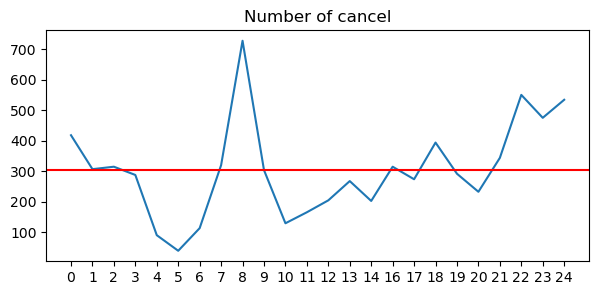

In [17]:
fig, ax_1 = plt.subplots(figsize=(7, 3))

#рисуем кривую по данным датафрейма
sns.lineplot(y=cancel_datetime.values(), x=cancel_datetime.keys())
#Рисуем прямую - среднее значение
ax_1.axhline(meann, color='red')
#Настраиваем ось x
ax_1.set_xticks(list(cancel_datetime.keys()))
ax_1.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24])
plt.title('Number of cancel')

In [18]:
#Словарь для распределения отказов по часам когда водитель не назначен
cancel_datetime_dr_not_ass = {}
#Словарь для распределения отказов по часам когда водитель назначен
cancel_datetime_dr_ass = {}
#Словарь для распределения отказов по часам когда отказано системой
cancel_datetime_by_system = {}

In [19]:
cancel_datetime_dr_not_ass = create_time_dict(cancel_datetime_dr_not_ass)

cancel_datetime_dr_ass = create_time_dict(cancel_datetime_dr_ass)

cancel_datetime_by_system = create_time_dict(cancel_datetime_by_system)

In [52]:
# Заполняем слвари с оттменными заказами по разным причинам
fill_dct(cancel_datetime_dr_not_ass, 4, 0)

fill_dct(cancel_datetime_dr_ass, 4, 1)

fill_dct(cancel_datetime_by_system, 9, 0)

# Словарь с кол-вом отказов и временем ожидания всего
cancel_time_datetime = {}

Text(0.5, 1.0, 'Number of cancel')

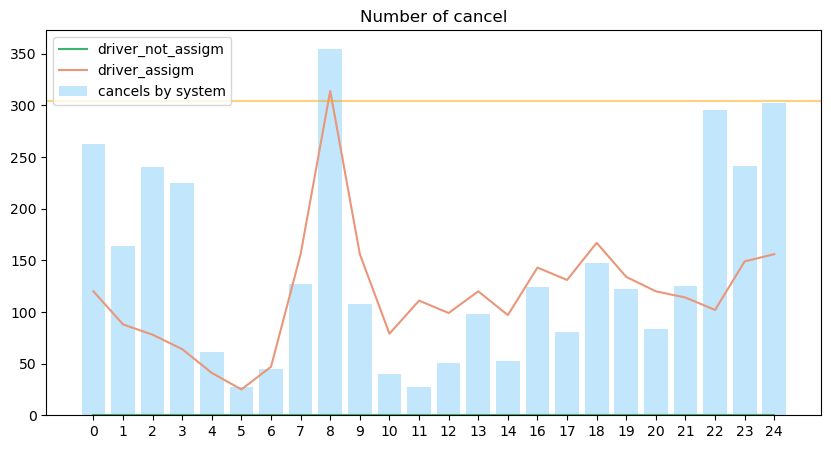

In [23]:
fig_2, ax_2 = plt.subplots(figsize=(10, 5))

#Кривая - отмены заказов по часам когда водитель не назначен
sns.lineplot(y=cancel_datetime_dr_not_ass.values(), x=cancel_datetime_dr_not_ass.keys(), color='mediumseagreen', label='driver_not_assigm')

#Кривая - отмены заказов по часам когда водитель назначен
sns.lineplot(y=cancel_datetime_dr_ass.values(), x=cancel_datetime_dr_ass.keys(), color='darksalmon', label='driver_assigm')

#Кривая - отмены заказов системой по часам
plt.bar(cancel_datetime_by_system.keys(), height=list(cancel_datetime_by_system.values()), color='lightskyblue', label='cancels by system', alpha=0.5)

#Рисуем прямую - среднее значение
ax_2.axhline(meann, color='orange', alpha=0.5)
#Настраиваем ось x
ax_2.set_xticks(list(cancel_datetime.keys()))
ax_2.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24])
ax_2.legend()
plt.title('Number of cancel')

* driver not assigm - отмены заказов по часам когда водитель не назначен
* driver assigm - отмены заказов по часам когда водитель назначен
* cancels by system - отмены заказов системой по часам

### Итоги раздела

В течении дня, отмены заказов показывают максимальные значения в 8 утра, и после 21ч. вечера 
Это пиковое врем когда происходит максимальное кол-во заказов

На графике видно, что все кривые двигаются в одном направлении, но кривая отказов когда водитель не назначен чаще всего опережает другие
Самый большой разрыв получается после 8 часов вечера 

Данный график показывает максимальное значение отказов во время часа пик, то есть когда кол-во заказов является максимальным. Если сопоставить с предыдущими графиками, которые говорят о том, что больше всего отказов со стороны клиента, когда водитель не назначен. Это может говорить о том, что во время большого трафика не хватает водителей, что приводит к долгому ожиданию клиента.

Стоит рассмотреть распределение времени ожидания такси, перед тем как произошла отмена со стороны клиента

# Вопрос 4
***Построить среднее время до отмены заказа с водителем и без водителя по часам. Если в данных есть выбросы, лучше их удалить. Можно ли из этого графика сделать какие-либо выводы?***


## Создаем график распределения времени ожидания такси до отмены заказа

Text(0.5, 1.0, 'delay distribution')

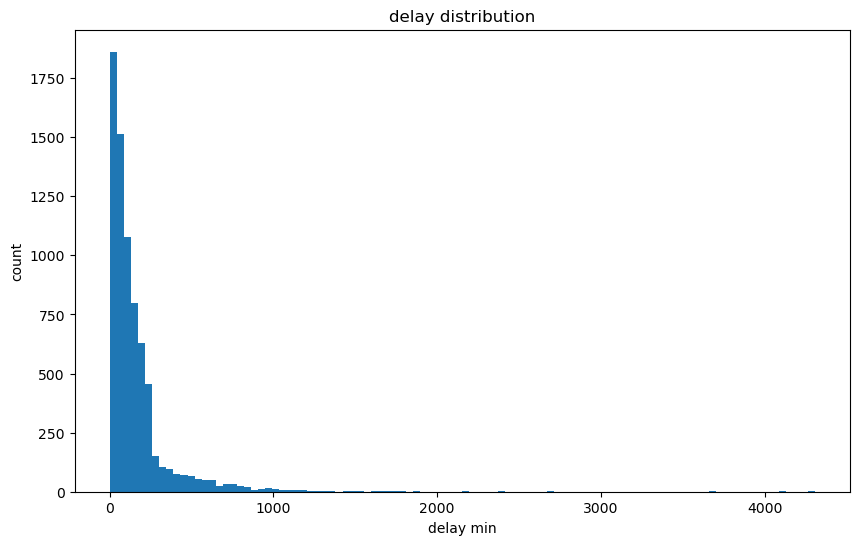

In [24]:
delay = data_orders_df['cancellations_time_in_seconds'].dropna() #столбец из основного DF со врменем ожидания такси
average_time_of_cancel = delay.mean() #Среднее значение ожидания такси

plt.figure(figsize = (10, 6))

plt.hist(delay, bins=100) #Диапозон разбит на 100 столбцов, чтобы видеть наличие выбросов
plt.xlabel('delay min')
plt.ylabel('count')
plt.title('delay distribution')

### Создаем график boxplot для визуализации выбросов

Text(0.5, 1.0, 'delay distribution and emission')

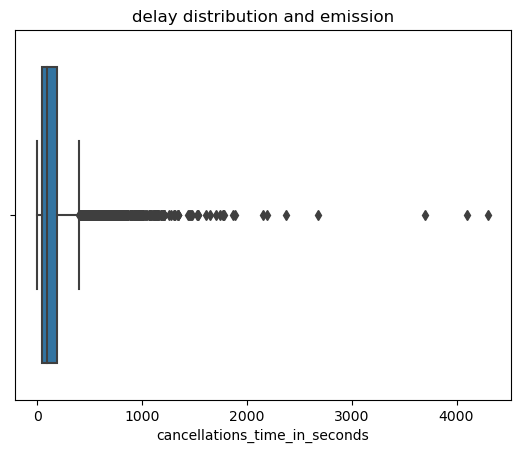

In [25]:
sns.boxplot(x=delay)
plt.title('delay distribution and emission')

График показывает выбросы, они могут быть следствием ошибок системы или исключительных случаев, которые являются не стандартными для работы такси

Cреднее значение времени, которое клиент ожидает машины перед тем как оменить заказ: 157.89 сек

In [26]:
Q1 = np.percentile(delay, 25, method='midpoint') #1й прецентиль
Q3 = np.percentile(delay, 75, method='midpoint') #3й прецентиль
inter_q = Q3 - Q1  #Межквартильный размах
mediana = statistics.median(delay) #медиана

### Находим время ожидания без выбросов

In [27]:
#Граница распределения, нормального диапазона DS
deadline = mediana + (inter_q * 1.5)
#Создаем новую переменную, содержащую значения времени без выбросов
delay_w_out_emprss = delay[delay <= deadline]
delay_w_out_emprss.mean()

101.44318181818181

Text(0, 0.5, 'count')

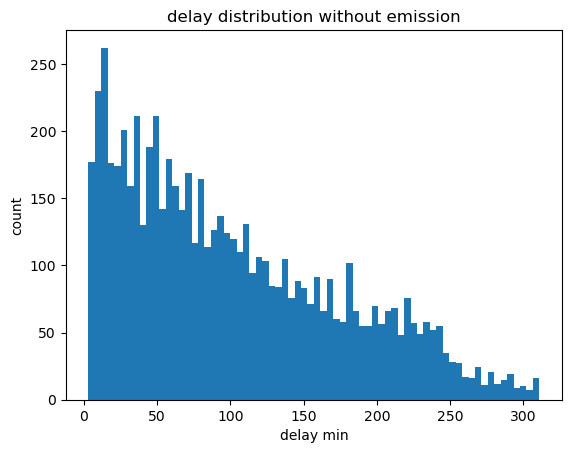

In [28]:
plt.hist(delay_w_out_emprss, bins = 70)
plt.title('delay distribution without emission')
plt.xlabel('delay min')
plt.ylabel('count')

Среднее время ожидания такси: 101.44

Text(0, 0.5, 'count')

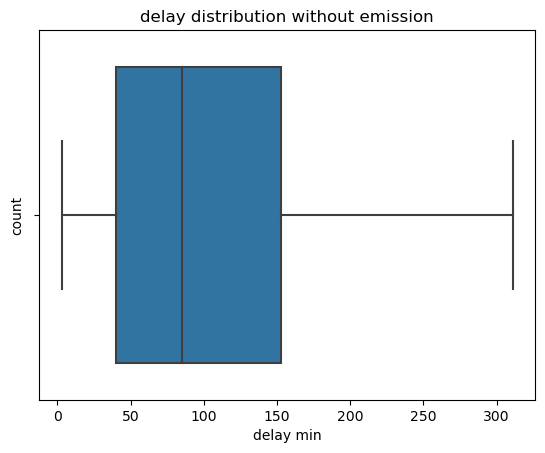

In [29]:
sns.boxplot(x=delay_w_out_emprss)
plt.title('delay distribution without emission')
plt.xlabel('delay min')
plt.ylabel('count')

### Создаем распределение времени ожидания такси с назначенным водителем и без назначенного водителя

Text(0.5, 1.0, 'taxi expactation with driver')

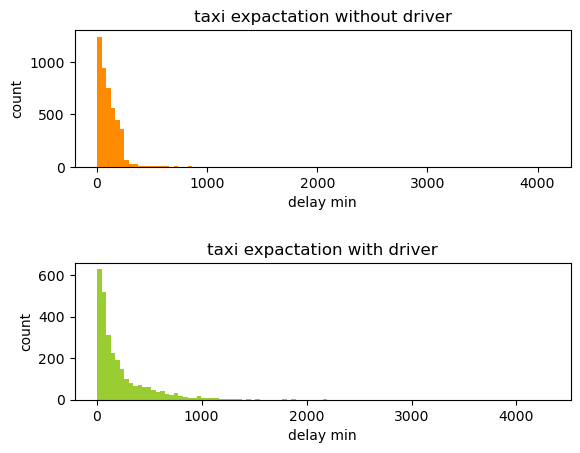

In [30]:
fig, (ax1, ax2) = plt.subplots(2)
fig.subplots_adjust(hspace=0.7)

taxi_expactation_w_o_dr = data_orders_df['cancellations_time_in_seconds'][data_orders_df['is_driver_assigned_key'] == 0].dropna() #столбец из основного DF со врменем ожидания такси
taxi_expactation_with_dr = data_orders_df['cancellations_time_in_seconds'][data_orders_df['is_driver_assigned_key'] == 1].dropna() #столбец из основного DF со врменем ожидания такси



ax1.hist(taxi_expactation_w_o_dr, bins=100, color='darkorange') #Диапозон разбит на 100 столбцов, чтобы видеть наличие выбросов
ax1.set_xlabel('delay min')
ax1.set_ylabel('count')
ax1.set_title('taxi expactation without driver')

ax2.hist(taxi_expactation_with_dr, bins=100, color='yellowgreen') #Диапозон разбит на 100 столбцов, чтобы видеть наличие выбросов
ax2.set_xlabel('delay min')
ax2.set_ylabel('count')
ax2.set_title('taxi expactation with driver')

### Создаем график boxplot для визуализации выбросов

Text(0.5, 1.0, 'taxi_expactation with driver distribution and emission')

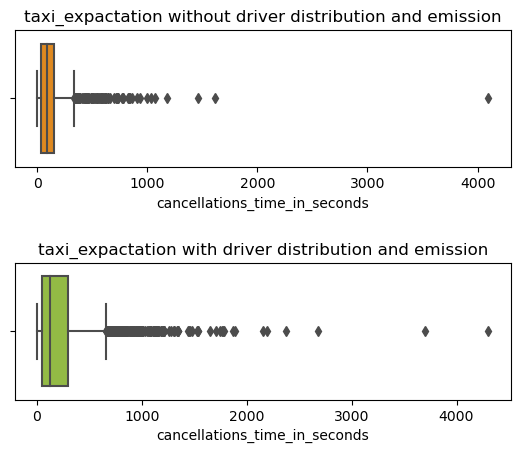

In [31]:
fig, (ax1, ax2) = plt.subplots(2)
fig.subplots_adjust(hspace=0.7)

sns.boxplot(x=taxi_expactation_w_o_dr, color='darkorange', ax=ax1)
ax1.set_title('taxi_expactation without driver distribution and emission')

sns.boxplot(x=taxi_expactation_with_dr, color='yellowgreen', ax=ax2)
ax2.set_title('taxi_expactation with driver distribution and emission')

In [32]:
Q1_wo_dr = np.percentile(taxi_expactation_w_o_dr, 25, method='midpoint') #1й прецентиль
Q3_wo_dr = np.percentile(taxi_expactation_w_o_dr, 75, method='midpoint') #3й прецентиль
inter_q_wo_dr = Q3_wo_dr - Q1_wo_dr  #Межквартильный размах
mediana_wo_dr = statistics.median(taxi_expactation_w_o_dr) #медиана

Q1_with_dr = np.percentile(taxi_expactation_with_dr, 25, method='midpoint') #1й прецентиль
Q3_with_dr = np.percentile(taxi_expactation_with_dr, 75, method='midpoint') #3й прецентиль
inter_q_with_dr = Q3_with_dr - Q1_with_dr  #Межквартильный размах
mediana_with_dr = statistics.median(taxi_expactation_with_dr) #медиана

### Находим время ожидания без выбросов

In [33]:
#Граница распределения, нормального диапазона DS
deadline_wo_dr = mediana_wo_dr + (inter_q_wo_dr * 1.5)
deadline_with_dr = mediana_with_dr + (inter_q_with_dr * 1.5)
#Создаем новую переменную, содержащую значения времени без выбросов
wo_dr_exp = taxi_expactation_w_o_dr[taxi_expactation_w_o_dr <= deadline_wo_dr]
with_dr_exp = taxi_expactation_with_dr[taxi_expactation_with_dr <= deadline_with_dr]

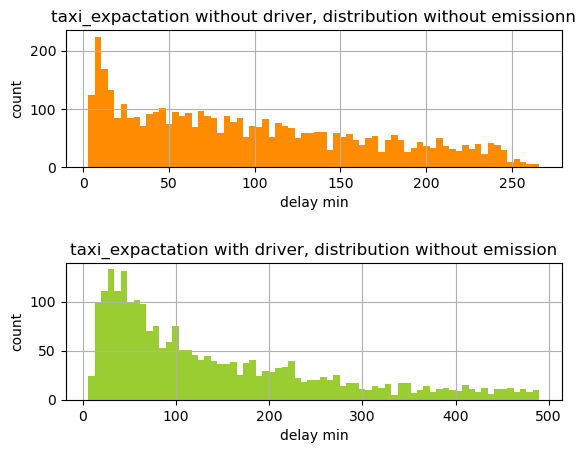

In [34]:
fig, (ax_1, ax_2) = plt.subplots(2)
fig.subplots_adjust(hspace=0.7)
#Первый график ожидания такси, когда водитель не назначен системой, без выбросов
ax_1.hist(wo_dr_exp, bins=70, color='darkorange')
ax_1.set_title('taxi_expactation without driver, distribution without emissionn')
ax_1.set_xlabel('delay min')
ax_1.set_ylabel('count')
ax_1.grid()
#Второй график ожидания такси, когда водитель назначен системой, без выбросов
ax_2.hist(with_dr_exp, bins=70, color='yellowgreen')
ax_2.set_title('taxi_expactation with driver, distribution without emission')
ax_2.set_xlabel('delay min')
ax_2.set_ylabel('count')
ax_2.grid()

**Сравнивая эти два графика, видно что клиенты быстрее отменяют заказ, если водитель не назначен Это подтверждает теорию, что часто проблемой является нехватка водителей.**

## Сделаем график среднего времени ожидания по часам 

***Словарь для среднего времени ожидания такси по часам***

Словарь для времени ожидания

In [35]:
#Делаем список из часов и словарь для подсчета отмен заказов по часам
cancel_time = {}
cancel_time = create_time_dict(cancel_time, 1)

***Также построим график кол-ва отмененнных заказов в зависимости от назначения водителя***

In [36]:
#Делаем словари:
#1 среднее время ожидания 'до назначения водителя' и кол-во заказов
cancel_time_dr_assigm = create_time_dict(cancel_time, 1)
#2 время ожидания после назначения водителя и кол-во заказов
cancel_time_dr_not_assigm = create_time_dict(cancel_time, 1)

**Словарь** когда заказы отменены _после назначения водителя_

In [37]:
time_keys = list(cancel_time_dr_assigm.keys())
for i in range(len(data_orders_df['order_gk'])):
    time_from_table = d.strptime(data_orders_df['order_datetime'][i], '%H:%M:%S').time()
    if pd.notnull(data_orders_df['cancellations_time_in_seconds'][i]) and data_orders_df['is_driver_assigned_key'][i] == 1:
        for j in range(23):
            if time_from_table >= d.strptime(time_keys[j], '%H:%M:%S').time() and time_from_table < d.strptime(time_keys[j + 1], '%H:%M:%S').time():
                cancel_time_dr_assigm[time_keys[j]][0] += 1
                cancel_time_dr_assigm[time_keys[j]][1] += data_orders_df['cancellations_time_in_seconds'][i]
        if time_from_table >= d.strptime(time_keys[23], '%H:%M:%S').time():
            cancel_time_dr_assigm[time_keys[23]][0] += 1
            cancel_time_dr_assigm[time_keys[23]][1] += data_orders_df['cancellations_time_in_seconds'][i]

**Словарь** когда заказы отменены _до назначения водителя_

In [38]:
time_keys = list(cancel_time.keys())
for i in range(len(data_orders_df['order_gk'])):
    time_from_table = d.strptime(data_orders_df['order_datetime'][i], '%H:%M:%S').time()
    if pd.notnull(data_orders_df['cancellations_time_in_seconds'][i]) and data_orders_df['is_driver_assigned_key'][i] == 0:
        for j in range(23):
            if time_from_table >= d.strptime(time_keys[j], '%H:%M:%S').time() and time_from_table < d.strptime(time_keys[j + 1], '%H:%M:%S').time():
                cancel_time_dr_not_assigm[time_keys[j]][0] += 1
                cancel_time_dr_not_assigm[time_keys[j]][1] += data_orders_df['cancellations_time_in_seconds'][i]
        if time_from_table >= d.strptime(time_keys[23], '%H:%M:%S').time():
            cancel_time_dr_not_assigm[time_keys[23]][0] += 1
            cancel_time_dr_not_assigm[time_keys[23]][1] += data_orders_df['cancellations_time_in_seconds'][i]

#### Строим график 

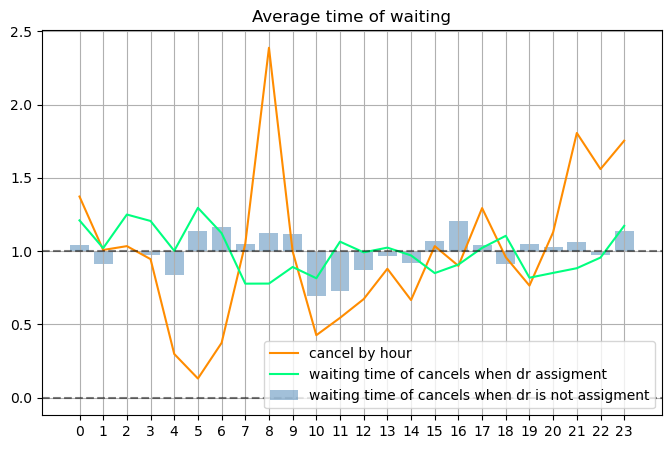

In [39]:
fig, ax = plt.subplots(figsize=(8, 5))

y2 = [round(values[1]/values[0], 3) for values in cancel_time_dr_not_assigm.values()]
ys = [round(j/i, 3) for i, j in cancel_time_dr_assigm.values()]
xs = [int(i.split(':')[0]) for i in cancel_time_dr_assigm.keys()]


#avg_time_df = pd.DataFrame(positive_x, ys)

#Кол-во отказов по часам
plt.title('Average time of waiting')
d_1 = statistics.mean(list(cancel_datetime.values()))
sns.lineplot(y=[i/d_1 for i in cancel_datetime.values()], x=cancel_datetime.keys(), color='darkorange', label='cancel by hour')

#Среднее время ожидания 'после назначения водителя' и кол-во заказов
d_2 = statistics.mean(ys)
sns.lineplot(y=[j/d_2 for j in ys], x=cancel_time_dr_assigm.keys(), color='springgreen', label='waiting time of cancels when dr assigment')

#Создаем список из среднего время ожидания
y2 = [round(values[1]/values[0], 3) for values in cancel_time_dr_not_assigm.values()]
#находим среднее время ожтдания 'до назначения водителя' 
d_3 = statistics.mean(y2)
#Среднее время ожидания 'до назначения водителя' и кол-во заказов
y2_2 = np.array([round(values[1]/values[0], 3)/d_3 for values in cancel_time_dr_not_assigm.values()])
#Строим график
plt.bar(cancel_time_dr_not_assigm.keys(), y2_2 - 1, bottom=1, color='steelblue', label='waiting time of cancels when dr is not assigment', alpha=0.5)

plt.axhline(y=1,  linestyle='--',  alpha=0.5,color='k')
plt.axhline(y=0,  linestyle='--',  alpha=0.5, color='k')

# Устанавливаем метки на оси x и их подписи
ax.set_xticks(xs)  # Устанавливаем метки на оси x
ax.set_xticklabels([i for i in xs])  # Устанавливаем подписи к этим меткам
ax.grid()
ax.legend()

In [65]:
print(round(min(y2[8], y2[9], y2[10]) / 60, 2), '-', round(max(y2[8], y2[9], y2[10]) / 60, 2), 'мин - среднее время ожидания назначения водителя перед тем как отменить заказ')

1.24 - 2.01 мин - среднее время ожидания назначения водителя перед тем как отменить заказ


* Cancel by hour - Кол-во отказов от такси по часам
* Cancels when dr assigment - Среднее время ожидания такси до отказа, когда водитель уже назначен
* Cancels when dr is not assigment - Среднее время ожидания такси до отказа, когда водитель уже назначен

##### Мы видим в 5 утра резкое падение отказов от заказов такси 
* В 5утра падение кол-ва отказов упало до значений менее 50 % от среднего кол-ва отказов в течении суток

##### В 8 утра резкий подъем кол-ва отказов
* Среднее кол-во отказов в это время превышает 200 % от среднего значения за сутки
* Время ожидания такси до отказа пока водитель не назначен имеет значение выше среднего (около 25%), в то время как среднее время ожидания когда водитель назначен наоборот ниже среднего на примерно то же значение

##### В дальнешем видим постепенный рост кол-во отказов, достигающий локального максимума в 21:00

* 1.0 средняя величина всех показателей

_Исходя из графика можно сказать что кол-во отмен заказов лучше коррелирует со временем ожидания такси пока водитель не назначен.
Это может говорить о том, что в пиковое время не хватает водителей, и пассажиры отказываются от заказа из-за долгого поиска водителя_

## Корреляция между временем ожидания назначения водителя и кол-вом отмен заказов

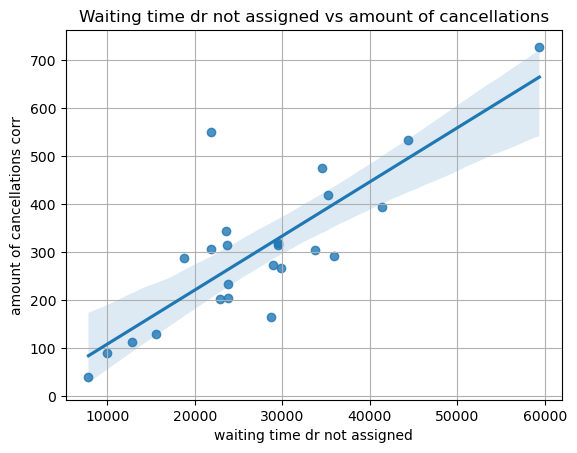

In [40]:
fig, ax = plt.subplots()
x_corr = [j for i, j in cancel_time_dr_assigm.values()]
y_corr = [i for i in cancel_datetime.values()]

sns.regplot(x=x_corr, y=y_corr)
plt.title('Waiting time dr not assigned vs amount of cancellations')
ax.set_xlabel('waiting time dr not assigned')
ax.set_ylabel('amount of cancellations corr')
ax.grid()

Мы видими на графике, что есть линейная зависимость
Стоит проверить насколько точной может быть линейная регресcия

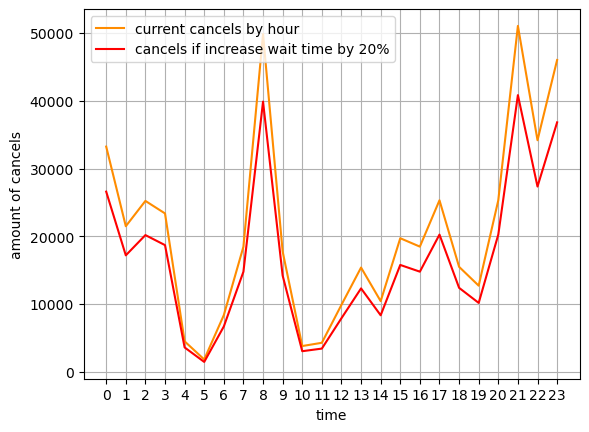

In [41]:
fig, ax = plt.subplots()

x_train = np.array([i[0] for i in cancel_time_dr_not_assigm.values()]).reshape(-1, 1)
y_train = np.array([i[0] for i in cancel_time_dr_not_assigm.values()])

lnr_model = LinearRegression()
lnr_model.fit(x_train, y_train)


test = np.array([values[1] * 0.8 for values in cancel_time_dr_not_assigm.values()]).reshape(-1, 1)
test_2 = np.array([values[1] for values in cancel_time_dr_not_assigm.values()])
cancels_sum = lnr_model.predict(test)

sns.lineplot(y=test_2, x=cancel_datetime.keys(), color='darkorange', label='current cancels by hour')
sns.lineplot(y=cancels_sum, x=cancel_datetime.keys(), color='red', label='cancels if increase wait time by 20%')

ax.set_xticks(xs)  # Устанавливаем метки на оси x
ax.set_xticklabels([i for i in xs])  # Устанавливаем подписи к этим меткам
ax.set_xlabel('time')
ax.set_ylabel('amount of cancels')
ax.grid()

График показывает как изменится кол-во отказов клиентов от такси, если уменшить кол-во времени ожидания такси на 20%

Данный график показывает не идеальное решение, так как линейная регрессия не достаточно качественно описывает зависимость кол-ва отказов от времени ожидания такси.
Но таких показателей достаточно чтобы сказать, что можно значительно уменшить кол-во отказов клиентов за счет уменьшения времени ожидания, особенно в пиковое время, когда отказов особенно много.
Здесь можно наблюдать что в зависимости часа, умеьшение отказов составляет 20% с разными долями процента. В пиковое время физичекое число отказов составляет большую часть всех отказов за сутки

Возможным выходом будет увеличение заработка водителей в пиковые часы, привлекая новых работников. Это поможет значительн уменшить кол-во отмененных заказов

# Вопрос 5 
***Построить распределение среднего времени до прибытия (ETA) по часам. Как можно объяснить этот график?***

In [42]:
#Создание словаря с колисевьом заказов и времени прибытия
eta_dct = {}
eta_dct = create_time_dict(eta_dct, 2)

In [43]:
#Заполнение словаря
time_keys = list(cancel_time.keys())
for i in range(len(data_orders_df['order_gk'])):
    time_from_table = d.strptime(data_orders_df['order_datetime'][i], '%H:%M:%S').time()
    if pd.notnull(data_orders_df['m_order_eta'][i]):
        for j in range(23):
            if time_from_table >= d.strptime(time_keys[j], '%H:%M:%S').time() and time_from_table < d.strptime(time_keys[j + 1], '%H:%M:%S').time():
                eta_dct[time_keys[j]][0] += 1
                eta_dct[time_keys[j]][1] += data_orders_df['m_order_eta'][i]
        if time_from_table >= d.strptime(time_keys[23], '%H:%M:%S').time():
            eta_dct[time_keys[23]][0] += 1
            eta_dct[time_keys[23]][1] += data_orders_df['m_order_eta'][i]

### График ETA

Text(0.5, 1.0, 'average ETA')

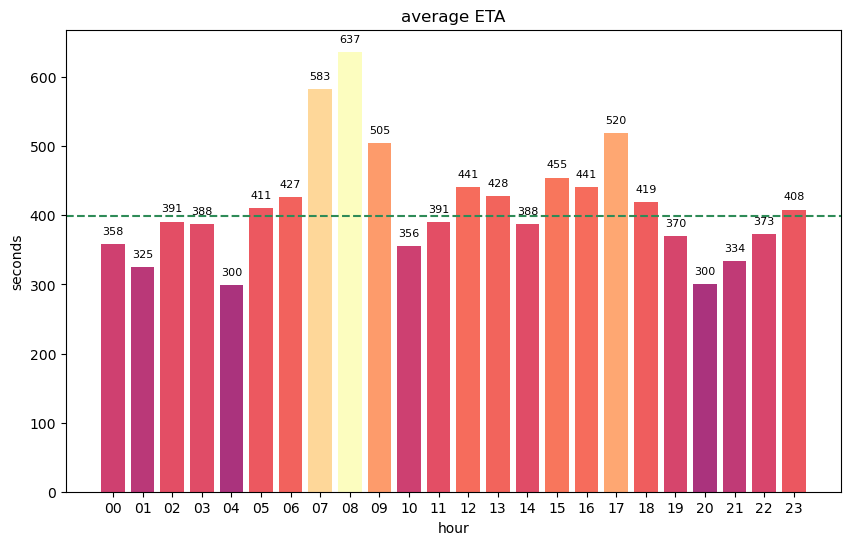

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))

y = [time/count for count, time in eta_dct.values()]  #Значения ETA по времени суток
x = [hour.split(':')[0] for hour in eta_dct.keys()]

mediana_eta = statistics.median(y)     # Медианное значение ETA по времени суток

colors = plt.cm.magma(y / max(y))

plt.bar(x, height=y, color=colors)
plt.axhline(mediana_eta, color='seagreen', linestyle='--')

for i in range(len(x)):
    plt.annotate(round(y[i]), (x[i], y[i]), textcoords="offset points", xytext=(0,7), ha='center', fontsize=8, color='black')

ax.set_xticks(x)
ax.set_xticks(x)

ax.set_ylabel('seconds')
ax.set_xlabel('hour')
plt.title('average ETA')

* Из графика ETA видно:
    + Самое долгое время прибытия такси показывает время 7, 8, 9 утра и 17:00 вечера
    + Эти показатели хорошо коррелируют с кол-вом отмененных заказов по часам


_Этот график показывает какие часы являются пиковыми. И в это же время растет кол-во отмененных заказов_

# Ключевые причины отмененных заказов

* Сравнивая результаты, мы можем обнаружить, что отсутствие водителя за клиентом является наиболее частой причиной отмены заказов.
* Рассматривая среднее значение по отменам заказов, около половины часов в течении дня показывают кол-во отмен больше среднего значения
* Утром с 7 до 9 часов наибольшее кол-во отменных заказов и самое длительное время ожидания такси с назначенным водителем. Причиной является высокая загруженность дорог, что приводит к нехватке водителей и большому кол-ву отказов.
* С утра, в час пик 7-9ч среднее время ожидания назначения системой водителя составляет 1.24 - 2.01 мин.
* Самое длительное время ожидания такси в 8 часов утра - 10,6 мин

# Методы снижения процента отмены заказов.

* Главной проблемой является нехватка водителей, особенно это сказывается во время большого траффика. Увелича кол-во водителей на 20% примерное кол-во отмененных заказов увеличется на 18 - 21 %. Эффективным решением будет привлечение водителей такси на смены с 7:00 до 9:00 утра и с 19:00 до 23:00 вечера, путем увеличени тарифного плана в данные часы.

* Также это будет способствовать меньшему времени ожидания такси при уже назначеннном водителе ввиду лучшего расположения в городе